Dataset shape after loading and labeling: (309392, 9)
Label Counts: event_label
0    221892
2     67123
1     20377
Name: count, dtype: int64


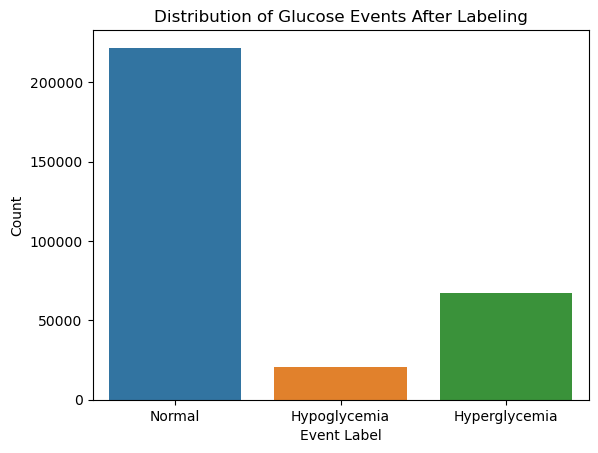

Dataset shape after fixing columns: (309392, 11)
Dataset shape after feature engineering: (309392, 14)


/Users/zinaghottis/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
3868/3868 ━━━━━━━━━━━━━━━━━━━━ 123s 31ms/step - accuracy: 0.7554 - loss: 0.3505 - val_accuracy: 0.8844 - val_loss: nan
Epoch 2/20
3868/3868 ━━━━━━━━━━━━━━━━━━━━ 117s 30ms/step - accuracy: 0.8921 - loss: 0.1805 - val_accuracy: 0.9131 - val_loss: nan
Epoch 3/20
3868/3868 ━━━━━━━━━━━━━━━━━━━━ 124s 32ms/step - accuracy: 0.8979 - loss: 0.1758 - val_accuracy: 0.8948 - val_loss: nan
Epoch 4/20
3868/3868 ━━━━━━━━━━━━━━━━━━━━ 128s 33ms/step - accuracy: 0.9010 - loss: 0.1705 - val_accuracy: 0.9303 - val_loss: nan
Epoch 5/20
3868/3868 ━━━━━━━━━━━━━━━━━━━━ 132s 34ms/step - accuracy: 0.8994 - loss: 0.1712 - val_accuracy: 0.9394 - val_loss: nan
Epoch 6/20
3868/3868 ━━━━━━━━━━━━━━━━━━━━ 143s 37ms/step - accuracy: 0.9029 - loss: 0.1655 - val_accuracy: 0.9385 - val_loss: nan
Epoch 7/20
3868/3868 ━━━━━━━━━━━━━━━━━━━━ 144s 37ms/step - accuracy: 0.9030 - loss: 0.1667 - val_accuracy: 0.9483 - val_loss: nan
Epoch 8/20
3868/3868 ━━━━━━━━━━━━━━━━━━━━ 176s 46ms/step - accuracy: 0.9031 - loss: 0.1670

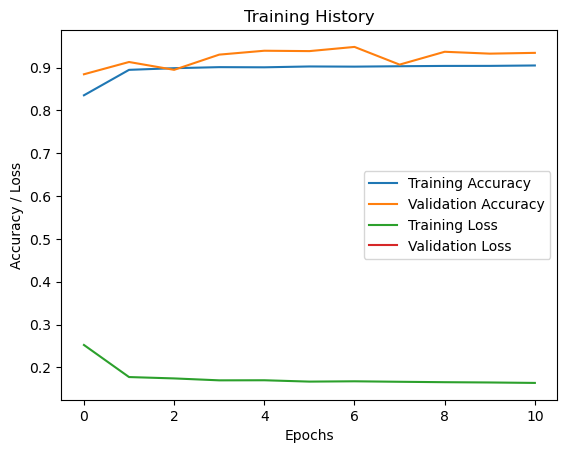

In [8]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Path to dataset
dataset_path = "/Users/zinaghottis/Downloads/HUPA-UCM Diabetes Dataset/Preprocessed"

# 1. Label Glucose Events (Hypoglycemia, Hyperglycemia, Normal) - **before merging**
def label_glucose_events(data, hypo_threshold=70, hyper_threshold=180):
    """
    Labels glucose events into three categories:
    - 0: Normal (70 <= glucose <= 180)
    - 1: Hypoglycemia (glucose < 70)
    - 2: Hyperglycemia (glucose > 180)
    """
    labels = []
    for glucose in data['glucose']:
        if pd.isna(glucose):  # Skip NaN glucose values
            labels.append(None)
        elif glucose < hypo_threshold:
            labels.append(1)  # Hypoglycemia
        elif glucose > hyper_threshold:
            labels.append(2)  # Hyperglycemia
        else:
            labels.append(0)  # Normal
    return np.array(labels)

# Load and label the data from all CSV files
def load_and_label_data(directory):
    all_data = []
    for file in os.listdir(directory):
        if file.endswith(".csv"):
            file_path = os.path.join(directory, file)
            data = pd.read_csv(file_path, delimiter=';')
            data['time'] = pd.to_datetime(data['time'], errors='coerce')
            
            # Label glucose events before merging
            data['event_label'] = label_glucose_events(data)
            
            # Drop rows with NaN labels
            data.dropna(subset=['event_label'], inplace=True)
            
            all_data.append(data)
    
    merged_data = pd.concat(all_data, ignore_index=True)
    print(f"Dataset shape after loading and labeling: {merged_data.shape}")
    return merged_data

# Load and label the dataset
data = load_and_label_data(dataset_path)

label_counts = data['event_label'].value_counts()
print("Label Counts:", label_counts)

# Check the distribution of labels after labeling
sns.countplot(x='event_label', data=data)
plt.title("Distribution of Glucose Events After Labeling")
plt.xlabel("Event Label")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1, 2], labels=["Normal", "Hypoglycemia", "Hyperglycemia"])
plt.show()

# 2. Fix 'carb_input,Patient ID' column (after labeling)
def fix_columns(data):
    data[['carb_input', 'Patient ID']] = data['carb_input,Patient ID'].str.split(',', expand=True)
    data['carb_input'] = pd.to_numeric(data['carb_input'], errors='coerce')
    print(f"Dataset shape after fixing columns: {data.shape}")
    return data

data = fix_columns(data)

# 3. Feature Engineering - Create new features
def feature_engineering(data):
    data['glucose_rate_of_change'] = data['glucose'].diff() / (data['time'].diff().dt.total_seconds() / 60)
    data['insulin_carb_ratio'] = data['bolus_volume_delivered'] / (data['carb_input'] + 1e-6)
    data['activity_intensity'] = data['heart_rate'] * data['steps']
    print(f"Dataset shape after feature engineering: {data.shape}")
    return data

data = feature_engineering(data)

# 4. Normalize Features
def normalize_features(data, feature_columns):
    scaler = MinMaxScaler()
    data[feature_columns] = scaler.fit_transform(data[feature_columns])
    return data

feature_columns = ['glucose', 'glucose_rate_of_change', 'insulin_carb_ratio', 'activity_intensity', 'calories', 'basal_rate']
data = normalize_features(data, feature_columns)

# 5. Prepare Sequences for MLP (Flatten input data)
def create_sequences(data, feature_columns, target_column, seq_length=20):
    X, y = [], []
    data = data.reset_index(drop=True)
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i+seq_length][feature_columns].values.flatten())  # Flatten the sequence
        y.append(data.iloc[i+seq_length][target_column])
    return np.array(X), np.array(y)

X, y = create_sequences(data, feature_columns, 'event_label')

# One-hot encode labels for classification
y = to_categorical(y, num_classes=3)

# 6. Split Data into Train and Test sets
def split_data(X, y, test_size=0.2):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = split_data(X, y)

# 7. Compute Class Weights for Imbalanced Classes
def compute_class_weights(y_train):
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train.argmax(axis=1)), y=y_train.argmax(axis=1))
    class_weights = dict(enumerate(class_weights))
    return class_weights

class_weights = compute_class_weights(y_train)

# 8. Build the MLP Model
def build_model(input_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(3, activation='softmax'))  # 3 classes: Normal, Hypoglycemia, Hyperglycemia
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = build_model(X_train.shape[1])

# 9. Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 10. Train the Model
def train_model(X_train, y_train, X_test, y_test, model, class_weights, early_stopping):
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=20,
        batch_size=64,
        verbose=1,
        callbacks=[early_stopping],
        class_weight=class_weights  # Pass class weights to handle imbalance
    )
    return history

history = train_model(X_train, y_train, X_test, y_test, model, class_weights, early_stopping)

# 11. Model Evaluation
from sklearn.metrics import classification_report

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)

    print(classification_report(y_true, y_pred_classes, target_names=["Normal", "Hypoglycemia", "Hyperglycemia"]))
    return y_pred_classes

y_pred_classes = evaluate_model(model, X_test, y_test)

# 12. Visualize Training History
def plot_training_history(history):
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training History')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy / Loss')
    plt.legend()
    plt.show()

plot_training_history(history)


In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Dropout, BatchNormalization, Flatten, Attention
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Path to dataset
dataset_path = "/Users/zinaghottis/Downloads/HUPA-UCM Diabetes Dataset/Preprocessed"

# 1. Load and Merge Data
def load_and_merge_data(directory):
    all_data = []
    for file in os.listdir(directory):
        if file.endswith(".csv"):
            file_path = os.path.join(directory, file)
            data = pd.read_csv(file_path, delimiter=';')
            data['time'] = pd.to_datetime(data['time'], errors='coerce')
            all_data.append(data)
    return pd.concat(all_data, ignore_index=True)

# Load the dataset
data = load_and_merge_data(dataset_path)

# 2. Fix 'carb_input,Patient ID' column
data[['carb_input', 'Patient ID']] = data['carb_input,Patient ID'].str.split(',', expand=True)

# Convert 'carb_input' to numeric if it's not already
data['carb_input'] = pd.to_numeric(data['carb_input'], errors='coerce')

# Drop the original column
data.drop(columns=['carb_input,Patient ID'], inplace=True)

# 3. Feature Engineering
data['glucose_rate_of_change'] = data['glucose'].diff() / (data['time'].diff().dt.total_seconds() / 60)
data['insulin_carb_ratio'] = data['bolus_volume_delivered'] / (data['carb_input'] + 1e-6)
data['activity_intensity'] = data['heart_rate'] * data['steps']
data.dropna(inplace=True)

# Solution: Repeat patient IDs to match the number of rows in the dataset
patient_ids = ['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p9', 'p10', 'p11', 
               'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 
               'p23', 'p24', 'p25', 'p26', 'p27', 'p28']

# Repeat the patient IDs list enough times to cover all rows in the dataset
repeated_patient_ids = np.tile(patient_ids, int(np.ceil(len(data) / len(patient_ids))))

# Trim or slice to ensure it matches the exact length of the dataset
repeated_patient_ids = repeated_patient_ids[:len(data)]

# Assign to the DataFrame
data['Patient ID'] = repeated_patient_ids

# 4. Normalize Features
scaler = MinMaxScaler()
feature_columns = ['glucose', 'glucose_rate_of_change', 'insulin_carb_ratio', 'activity_intensity', 'calories', 'basal_rate']
data[feature_columns] = scaler.fit_transform(data[feature_columns])

# 5. Label Glucose Events (Hypoglycemia, Hyperglycemia, Normal)
def label_glucose_events(data, hypo_threshold=70, hyper_threshold=180):
    labels = []
    for glucose in data['glucose']:
        if glucose < hypo_threshold:
            labels.append(1)  # Hypoglycemia
        elif glucose > hyper_threshold:
            labels.append(2)  # Hyperglycemia
        else:
            labels.append(0)  # Normal
    return np.array(labels)

# Apply event labeling
data['event_label'] = label_glucose_events(data)

# Convert event labels to one-hot encoding
y = to_categorical(data['event_label'], num_classes=3)

# 6. Prepare Sequences for CNN-LSTM
def create_sequences(data, target_column, seq_length=20):
    X, y = [], []
    data = data.reset_index(drop=True)
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i+seq_length][feature_columns].values)
        y.append(data.iloc[i+seq_length][target_column])
    return np.array(X), np.array(y)

X, y = create_sequences(data, target_column='event_label')

# 7. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# 8. Define CNN-LSTM Model with Attention for Feature Extraction
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
cnn = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs)
cnn = BatchNormalization()(cnn)
cnn = Dropout(0.3)(cnn)
lstm = LSTM(128, return_sequences=True)(cnn)
attention = Attention()([lstm, lstm])  
flatten = Flatten()(attention)
dense = Dense(64, activation='relu')(flatten)
dense = Dropout(0.3)(dense)
output = Dense(1, activation='linear')(dense)

feature_extractor = Model(inputs, output)
feature_extractor.compile(optimizer='adam', loss='mse', metrics=['mae'])

# 9. Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 10. Train the Model
history = feature_extractor.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# 11. Plot Actual vs Predicted Glucose Levels for a Single Patient on a Specific Day
# Select a patient and day (for example, patient 'p1' on a specific day)
patient_data = data[data['Patient ID'] == 'p1']  # Select patient 'p1'
specific_day_data = patient_data[patient_data['time'].dt.date == pd.to_datetime("2023-08-15").date()]  # Select a specific day

# Normalize the features for prediction (use the same scaler)
scaled_features = scaler.transform(specific_day_data[feature_columns])

# Create sequences for prediction (use a sequence length of 20 as in the model)
X_sequence, _ = create_sequences(specific_day_data, target_column='event_label', seq_length=20)

# Predict glucose levels using the trained model
predicted_glucose = feature_extractor.predict(X_sequence)

# Unnormalize predicted glucose values
predicted_glucose_unnorm = scaler.inverse_transform(np.hstack([scaled_features[:, :4], predicted_glucose]))[:, 4]  # Unnormalize glucose only

# Plot the actual vs predicted glucose values
plt.figure(figsize=(10, 6))
plt.plot(specific_day_data['time'].iloc[20:], specific_day_data['glucose'].iloc[20:], label='Actual Glucose', color='blue')
plt.plot(specific_day_data['time'].iloc[20:], predicted_glucose_unnorm, label='Predicted Glucose', color='red', linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('Glucose Levels')
plt.title(f'Actual vs Predicted Glucose Levels for Patient {specific_day_data["Patient ID"].iloc[0]} on {specific_day_data["time"].iloc[0].date()}')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Epoch 1/20
6031/7735 ━━━━━━━━━━━━━━━━━━━━ 1:06 39ms/step - loss: 0.0779 - mae: 0.1554